In [58]:
import numpy as np
import argparse
import time
import os
from itertools import chain
import matplotlib.pyplot as plt
import multiprocessing as mp

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

from datasets import inputs
from sr_model.models.models import AnalyticSR, STDP_SR

## Collect the parameter range of interest
$$area=A\tau$$

In [59]:
def get_kernel_params(tau_0, A_0, tau_offset):
    area = A_0*tau_0
    new_tau = tau_0 + tau_offset
    new_A = area/new_tau
    return new_A, new_tau
    
def get_symm_kernel_params(tau_0, A_0, tau_offset):
    area = A_0*tau_0
    new_tau = tau_0 + tau_offset
    new_A = (area/2)/new_tau
    return new_A, new_tau

def get_stdp_kernel(
    A_pos, tau_pos, A_neg, tau_neg, kernel_len
    ):
    """ Returns plasticity kernel for plotting or debugging. """

    k = np.zeros(kernel_len)
    half_len = kernel_len//2
    scaling = 1
    k[:half_len] = scaling*A_neg * np.exp(
        np.arange(-half_len, 0)/tau_neg
        )
    k[-half_len-1:] = scaling*A_pos * np.exp(
        -1*np.arange(half_len+1)/tau_pos
        )
    return k

In [60]:
A_0 = 0.5
tau_0 = 1.15

In [61]:
# Order: [A_pos, tau_pos, A_neg, tau_neg]
set0 = get_kernel_params(tau_0, A_0, -0.5)
set1 = get_kernel_params(tau_0, A_0, -0.25)
set2 = get_kernel_params(tau_0, A_0, 0.5)
set3 = get_kernel_params(tau_0, A_0, 0.75)
set4 = get_symm_kernel_params(tau_0, A_0, -0)

params = [
    [A_0, tau_0, 0, 1],
    [set0[0], set0[1], 0, 1],
    [set1[0], set1[1], 0, 1],
    [set2[0], set2[1], 0, 1],
    [set3[0], set3[1], 0, 1],
    [set4[0], set4[1], set4[0], set4[1]],
    ]

errs = []

In [62]:
params

[[0.5, 1.15, 0, 1],
 [0.8846153846153847, 0.6499999999999999, 0, 1],
 [0.638888888888889, 0.8999999999999999, 0, 1],
 [0.34848484848484845, 1.65, 0, 1],
 [0.3026315789473684, 1.9, 0, 1],
 [0.25, 1.15, 0.25, 1.15]]

In [65]:
params = [                                                                      
    [A_0, tau_0, 0, 1],                                                         
    [A_0, set0[1], 0, 1],                                                       
    [A_0, set1[1], 0, 1],                                                       
    [A_0, set2[1], 0, 1],                                                       
    [A_0, set3[1], 0, 1],                                                       
    [A_0, set4[1], A_0, set4[1]],                                               
    ] 

[0.5, 1.15, 0, 1]


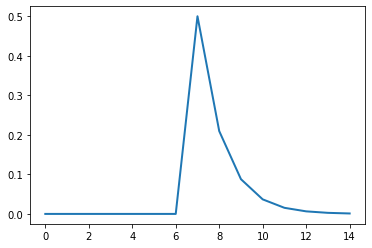

[0.5, 0.6499999999999999, 0, 1]


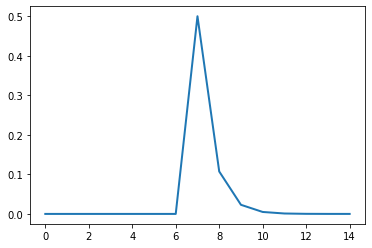

[0.5, 0.8999999999999999, 0, 1]


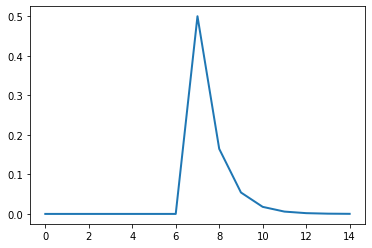

[0.5, 1.65, 0, 1]


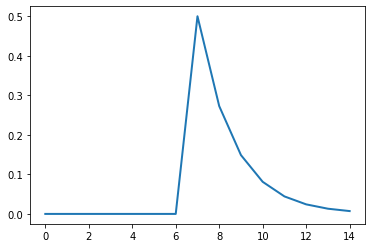

[0.5, 1.9, 0, 1]


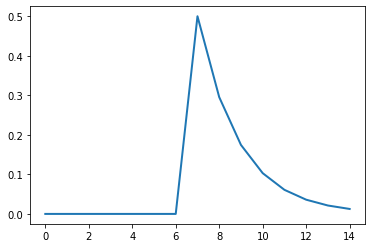

[0.5, 1.15, 0.5, 1.15]


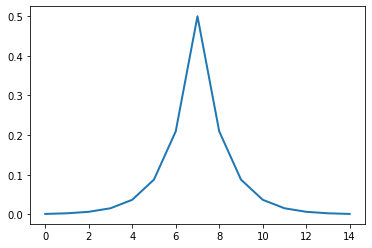

In [66]:
for param in params:
    print(param)
    k = get_stdp_kernel(
        param[0], param[1], param[2], param[3], 15
        )
    plt.figure()
    plt.plot(k, linewidth=2)
    plt.show()

## Initialize data structures

In [45]:
device = 'cpu'

# Dataset Configs
datasets = [ 
    ['1dwalk', inputs.Sim1DWalk(num_steps=1000, left_right_stay_prob=[5,1,1], num_states=64)],
    ['2dwalk', inputs.Sim2DWalk(num_steps=1000, num_states=64)],
    ['levyflight', inputs.Sim2DLevyFlight(num_steps=1000, walls=7)]
    ]

## Run through params

In [46]:
def eval_model(args):
    param, (dset_name, dset) = args
    
    net = STDP_SR(num_states=64, gamma=0.4)
    net.ca3.reset_trainable_ideal()
    net.ca3.set_differentiability(False)
    
    nn.init.constant_(net.ca3.A_pos, param[0])
    nn.init.constant_(net.ca3.tau_pos, param[1])
    nn.init.constant_(net.ca3.A_neg, param[2])
    nn.init.constant_(net.ca3.tau_neg, param[3])
    
    with torch.no_grad():
        dg_inputs = torch.from_numpy(dset.dg_inputs.T).float().to(device).unsqueeze(1)
        dg_modes = torch.from_numpy(dset.dg_modes.T).float().to(device).unsqueeze(1)
        _, outputs = net(dg_inputs, dg_modes, reset=True)
        est_T = net.ca3.get_T().detach().numpy()
        real_T = net.ca3.get_real_T()
        err = np.mean(np.abs(est_T - real_T))
    
    results = [param, dset_name, err]
    return results

In [47]:
args_list = []
for param in params:
    for dset_args in datasets:
        args_list.append([param, dset_args])

In [48]:
def main():
    pool = mp.Pool(7)
    result = pool.map(eval_model, args_list)
    return result

In [49]:
result = main()

In [50]:
result

[[[0.5, 1.15, 0, 1], '1dwalk', 1.696003280058261e-08],
 [[0.5, 1.15, 0, 1], '2dwalk', 2.968907163119705e-08],
 [[0.5, 1.15, 0, 1], 'levyflight', 7.504978697351527e-08],
 [[0.8846153846153847, 0.6499999999999999, 0, 1],
  '1dwalk',
  0.2330606953687438],
 [[0.8846153846153847, 0.6499999999999999, 0, 1],
  '2dwalk',
  0.6017478251313427],
 [[0.8846153846153847, 0.6499999999999999, 0, 1],
  'levyflight',
  0.07276236153532703],
 [[0.638888888888889, 0.8999999999999999, 0, 1],
  '1dwalk',
  0.028569968642723743],
 [[0.638888888888889, 0.8999999999999999, 0, 1],
  '2dwalk',
  0.03125002059881472],
 [[0.638888888888889, 0.8999999999999999, 0, 1],
  'levyflight',
  0.014525313263970158],
 [[0.34848484848484845, 1.65, 0, 1], '1dwalk', 0.4807945090142592],
 [[0.34848484848484845, 1.65, 0, 1], '2dwalk', 0.049634498220429146],
 [[0.34848484848484845, 1.65, 0, 1], 'levyflight', 0.05380457599218203],
 [[0.3026315789473684, 1.9, 0, 1], '1dwalk', 0.533869107196048],
 [[0.3026315789473684, 1.9, 0, 1],

## Plot Tau as a function of performance

In [5]:
# load results
result = [[[0.5, 1.15, 0, 1], '1dwalk', 0.013415306829583556],
 [[0.5, 1.15, 0, 1], '2dwalk', 0.0156250270603353],
 [[0.5, 1.15, 0, 1], 'levyflight', 0.007436624434066371],
 [[0.8846153846153847, 0.6499999999999999, 0, 1],
  '1dwalk',
  0.3305586109323132],
 [[0.8846153846153847, 0.6499999999999999, 0, 1],
  '2dwalk',
  0.36884151234484785],
 [[0.8846153846153847, 0.6499999999999999, 0, 1],
  'levyflight',
  0.09265087818315024],
 [[0.638888888888889, 0.8999999999999999, 0, 1],
  '1dwalk',
  1.700732564559048e-08],
 [[0.638888888888889, 0.8999999999999999, 0, 1],
  '2dwalk',
  2.8991837664566873e-08],
 [[0.638888888888889, 0.8999999999999999, 0, 1],
  'levyflight',
  7.632680565606353e-08],
 [[0.34848484848484845, 1.65, 0, 1], '1dwalk', 0.014252318069248678],
 [[0.34848484848484845, 1.65, 0, 1], '2dwalk', 0.015625027123221183],
 [[0.34848484848484845, 1.65, 0, 1], 'levyflight', 0.007948940370264843],
 [[0.3026315789473684, 1.9, 0, 1], '1dwalk', 0.01450562411933068],
 [[0.3026315789473684, 1.9, 0, 1], '2dwalk', 0.015625027123221183],
 [[0.3026315789473684, 1.9, 0, 1], 'levyflight', 0.008103983359708434],
 [[0.25, 1.15, 0.25, 1.15], '1dwalk', 0.014796375466901174],
 [[0.25, 1.15, 0.25, 1.15], '2dwalk', 0.01562502709040147],
 [[0.25, 1.15, 0.25, 1.15], 'levyflight', 0.008281945825157422]]

New coords: 1.15, 1.696003280058261e-08
New coords: 1.15, 2.968907163119705e-08
New coords: 1.15, 7.504978697351527e-08
New coords: 0.6499999999999999, 0.2330606953687438
New coords: 0.6499999999999999, 0.6017478251313427
New coords: 0.6499999999999999, 0.07276236153532703
New coords: 0.8999999999999999, 0.028569968642723743
New coords: 0.8999999999999999, 0.03125002059881472
New coords: 0.8999999999999999, 0.014525313263970158
New coords: 1.65, 0.4807945090142592
New coords: 1.65, 0.049634498220429146
New coords: 1.65, 0.05380457599218203
New coords: 1.9, 0.533869107196048
New coords: 1.9, 0.2048968211769003
New coords: 1.9, 0.09506392796207502
New coords: 0, 0.02471081845685278
New coords: 0, 0.06501096249811182
New coords: 0, 0.006371585652370719


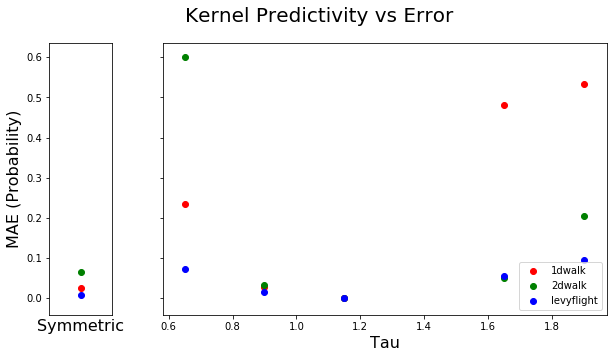

In [57]:
color=['r','g','b']
labeled = []
f, (ax0, ax1) = plt.subplots(
    1, 2, sharey=True, gridspec_kw={'width_ratios': [1, 7]},
    figsize=(10,5)
    )
for res in result:
    param, dset_name, err = res
    if '1d' in dset_name:
        c = color[0]
    elif '2d' in dset_name:
        c = color[1]
    else:
        c = color[2]
    if param[2] != 0:
        x = 0
        ax0.scatter(x, err, color=c)
    else:
        x = param[1]
        if dset_name not in labeled:
            label = dset_name
            labeled.append(dset_name)
        else:
            label = None
        ax1.scatter(x, err, color=c, label=label)
    print(f'New coords: {x}, {err}')
ax0.set_ylabel("MAE (Probability)", fontsize=16)
ax0.set_xticks([])
ax0.set_xlabel("Symmetric", fontsize=16)
ax1.set_xlabel("Tau", fontsize=16)
plt.legend()
plt.suptitle("Kernel Predictivity vs Error", fontsize=20)
plt.show()

In [2]:
def get_kernel_params(tau_0, A_0, tau_offset):
    area = A_0*tau_0
    new_tau = tau_0 + tau_offset
    new_A = area/new_tau
    return new_A, new_tau
    
def get_symm_kernel_params(tau_0, A_0, tau_offset):
    area = A_0*tau_0
    new_tau = tau_0 + tau_offset
    new_A = (area/2)/new_tau
    return new_A, new_tau

def get_stdp_kernel(
    A_pos, tau_pos, A_neg, tau_neg, kernel_len
    ):
    """ Returns plasticity kernel for plotting or debugging. """

    k = np.zeros(kernel_len)
    half_len = kernel_len//2
    scaling = 1
    k[:half_len] = scaling*A_neg * np.exp(
        np.arange(-half_len, 0)/tau_neg
        )
    k[-half_len-1:] = scaling*A_pos * np.exp(
        -1*np.arange(half_len+1)/tau_pos
        )
    return k

In [4]:
# Order: [A_pos, tau_pos, A_neg, tau_neg]
A_0 = 0.5
tau_0 = 1.15
set0 = get_kernel_params(tau_0, A_0, -0.5)
set1 = get_kernel_params(tau_0, A_0, -0.25)
set2 = get_kernel_params(tau_0, A_0, 0.5)
set3 = get_kernel_params(tau_0, A_0, 0.75)
set4 = get_symm_kernel_params(tau_0, A_0, -0)

params = [
    [A_0, tau_0, 0, 1],
    [set0[0], set0[1], 0, 1],
    [set1[0], set1[1], 0, 1],
    [set2[0], set2[1], 0, 1],
    [set3[0], set3[1], 0, 1],
    [set4[0], set4[1], set4[0], set4[1]],
    ]

errs = []

In [5]:
params

[[0.5, 1.15, 0, 1],
 [0.8846153846153847, 0.6499999999999999, 0, 1],
 [0.638888888888889, 0.8999999999999999, 0, 1],
 [0.34848484848484845, 1.65, 0, 1],
 [0.3026315789473684, 1.9, 0, 1],
 [0.25, 1.15, 0.25, 1.15]]

## Initialize data structures

In [10]:
device = 'cpu'

# Dataset Configs
dset = inputs.RBYCacheWalk(
    num_spatial_states=25*25,
    downsample_factor=None,
    skip_frame=0.7
    )

## Run through params

In [20]:
def eval_model(args):
    param = args
    
    net = STDP_SR(num_states=692, gamma=0.4)
    net.ca3.reset_trainable_ideal()
    net.ca3.set_differentiability(False)
    
    nn.init.constant_(net.ca3.A_pos, param[0])
    nn.init.constant_(net.ca3.tau_pos, param[1])
    nn.init.constant_(net.ca3.A_neg, param[2])
    nn.init.constant_(net.ca3.tau_neg, param[3])
    
    with torch.no_grad():
        dg_inputs = torch.from_numpy(dset.dg_inputs.T).float().to(device).unsqueeze(1)
        dg_modes = torch.from_numpy(dset.dg_modes.T).float().to(device).unsqueeze(1)
        _, outputs = net(dg_inputs, dg_modes, reset=True)
        est_T = net.ca3.get_T().detach().numpy()
        real_T = net.ca3.get_real_T()
        err = np.mean(np.abs(est_T - real_T))
        M0 = net.ca3.get_M_hat()
        M1 = net.ca3.get_M_hat(gamma=0.6)
    
    results = [param, M0, M1, err]
    return results

In [21]:
args_list = params

In [22]:
def main():
    pool = mp.Pool(1)
    result = pool.map(eval_model, args_list)
    return result

In [23]:
result = main()

Traceback (most recent call last):
Process ForkPoolWorker-3:
  File "/home/chingf/anaconda3/envs/aronov/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()


KeyboardInterrupt: 

  File "/home/chingf/anaconda3/envs/aronov/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/chingf/anaconda3/envs/aronov/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/chingf/anaconda3/envs/aronov/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "<ipython-input-20-1108e07693b5>", line 16, in eval_model
    _, outputs = net(dg_inputs, dg_modes, reset=True)
  File "/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/torch/nn/modules/module.py", line 889, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/home/chingf/Code/sr-project/src/sr_model/models/models.py", line 81, in forward
    self.update()
  File "/home/chingf/Code/sr-project/src/sr_model/models/models.py", line 99, in update
    self.ca3.update()
  File "/home/chingf/Code/sr-project/src/sr_model/models/ca3.py", line 12